In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist, cosine
from scipy.ndimage import convolve1d
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import tensorflow as tf
from joblib import Parallel, delayed

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

2025-05-16 17:07:48.914529: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 17:07:48.927050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747429668.940862 1390615 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747429668.945000 1390615 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747429668.955867 1390615 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
#ds = xr.open_dataset('../rainFlagRemovedBuoyDataBadQualityRemovedMatchup.nc')

ds = xr.open_dataset('goodData_QSwithTAO_with2hrStatsConv.nc')
df = ds.to_dataframe()
df_orig = df.copy()

In [3]:
list(df.keys())

['Wind Direction (TAO)',
 'WDIR_QC',
 'WDIR_DM',
 'Wind Speed (TAO)',
 'WSPD_QC',
 'WSPD_DM',
 'Zonal Wind Speed (TAO)',
 'Meridional Wind Speed (TAO)',
 'Sea Surface Temperature (TAO)',
 'SST_QC',
 'SST_DM',
 'Relative Humidity (TAO)',
 'RELH_QC',
 'RELH_DM',
 'Air Temperature (TAO)',
 'AIRT_QC',
 'AIRT_DM',
 'Neutral Wind Speed at 10m (TAO)',
 'Wind Speed at 10m (TAO)',
 'mean_WSPD',
 'std_WSPD',
 'mean_WSPD_10N',
 'std_WSPD_10N',
 'mean_SST',
 'std_SST',
 'mean_AIRT',
 'std_AIRT',
 'mean_SST - AIRT',
 'std_SST - AIRT',
 'mean_RELH',
 'std_RELH',
 'mean_U10N_x',
 'std_U10N_x',
 'mean_U10N_y',
 'std_U10N_y',
 'mean_cosWDIR',
 'std_cosWDIR',
 'mean_sinWDIR',
 'std_sinWDIR',
 'LATITUDE',
 'LONGITUDE',
 'TAO_TIME',
 'Deployment index',
 'Wind Speed (QuikSCAT)',
 'Wind Direction (QuikSCAT)',
 'rain_impact',
 'flags',
 'eflags',
 'nudge_wind_speed',
 'nudge_wind_direction',
 'retrieved_wind_speed_uncorrected',
 'cross_track_wind_speed_bias',
 'atmospheric_speed_bias',
 'wind_obj',
 'ambigu

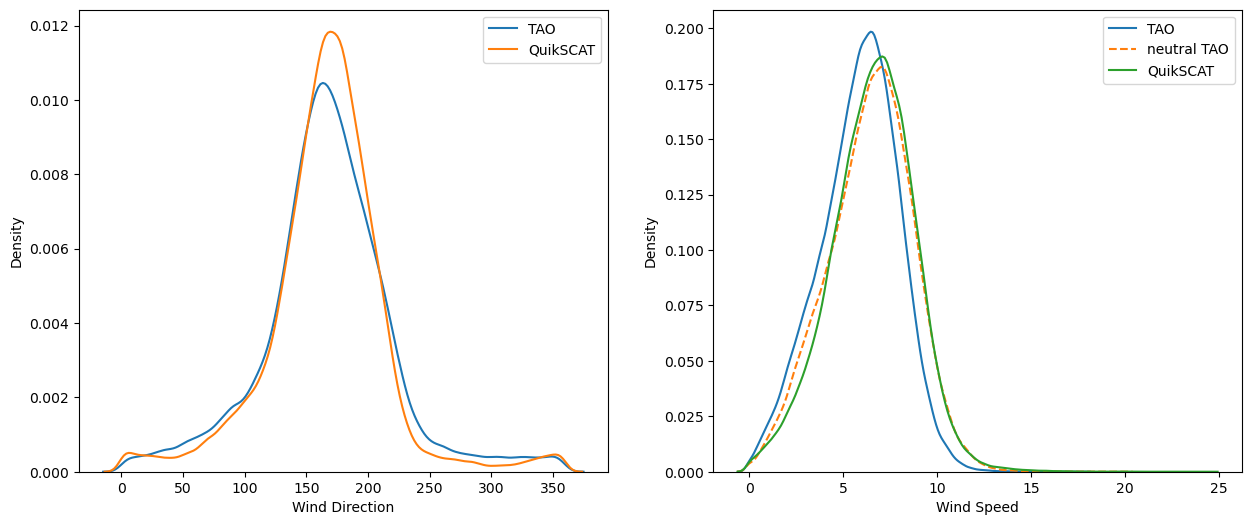

In [4]:
fig, axes = plt.subplots(ncols=2, figsize=(15,6))

ax = axes[0]
sns.kdeplot(df['Wind Direction (TAO)'], ax = ax, label = 'TAO')
#sns.kdeplot(df['mean WDIR 30min'], ax = ax, label = 'TAO (30 min mean)')
#sns.kdeplot(df['mean WDIR 60min'], ax = ax, label = 'TAO (1 hr mean)')
#sns.kdeplot(df['mean WDIR 120min'], ax = ax, label = 'TAO (2 hr mean)')
sns.kdeplot(df['Wind Direction (QuikSCAT)'], ax = ax, label = 'QuikSCAT')
ax.set_xlabel('Wind Direction')
ax.legend()

ax = axes[1]
sns.kdeplot(df['Wind Speed (TAO)'], ax = ax, label = 'TAO')
#sns.kdeplot(df['mean WSPD 30min'], ax = ax, label = 'TAO (30 min mean)')
#sns.kdeplot(df['mean WSPD 60min'], ax = ax, label = 'TAO (1 hr mean)')
#sns.kdeplot(df['mean WSPD 120min'], ax = ax, label = 'TAO (2 hr mean)')

sns.kdeplot(df['Neutral Wind Speed at 10m (TAO)'], linestyle="--", ax = ax, label = 'neutral TAO')
#sns.kdeplot(df['mean WSPD_10N 30min'], linestyle="--", ax = ax, label = 'neutral TAO (30 min mean)')
#sns.kdeplot(df['mean WSPD_10N 60min'], linestyle="--", ax = ax, label = 'neutral TAO (1 hr mean)')
#sns.kdeplot(df['mean WSPD_10N 120min'], linestyle="--", ax = ax, label = 'neutral TAO (2 hr mean)')

sns.kdeplot(df['Wind Speed (QuikSCAT)'], ax = ax, label = 'QuikSCAT')
ax.set_xlabel('Wind Speed')
ax.legend()

np.float64(0.8659971464515444)

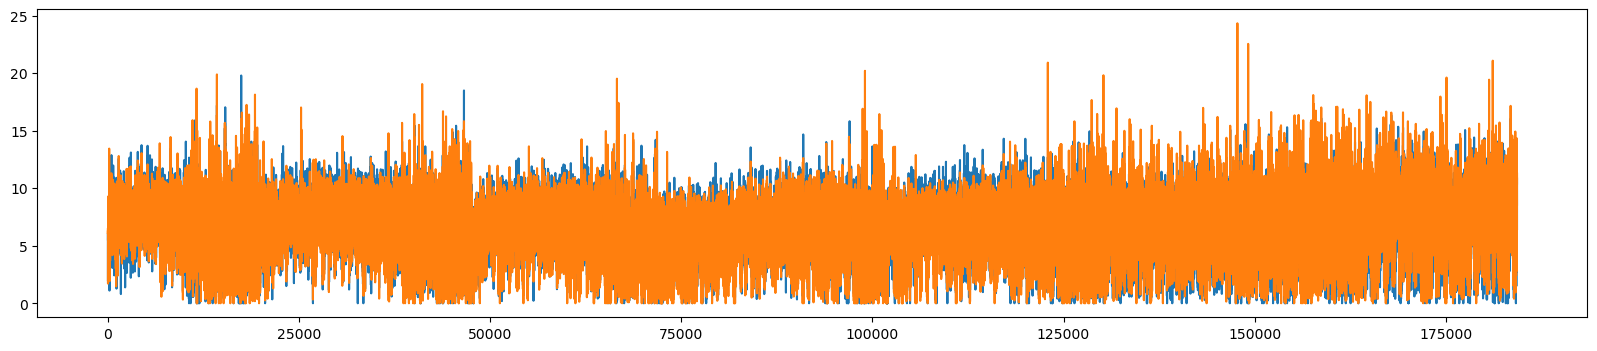

In [5]:
plt.figure(figsize=(20,4))
plt.plot(df['Neutral Wind Speed at 10m (TAO)'])
plt.plot(df['Wind Speed (QuikSCAT)'])
np.corrcoef(df['Wind Speed (TAO)'], df['Wind Speed (QuikSCAT)'])[0,1]

np.float64(0.671077822660057)

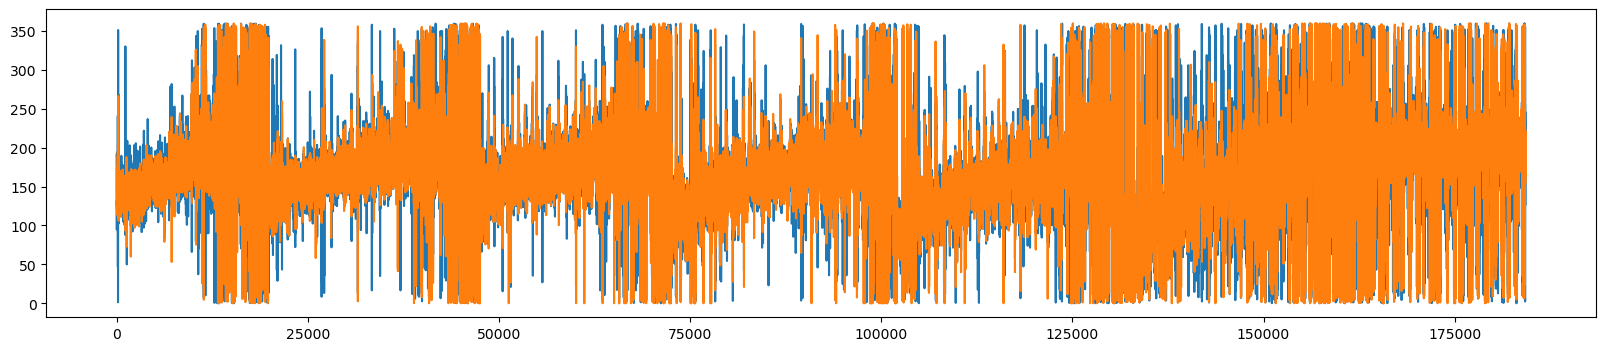

In [6]:
plt.figure(figsize=(20,4))
plt.plot(df['Wind Direction (TAO)'])
plt.plot(df['Wind Direction (QuikSCAT)'])
np.corrcoef(df['Wind Direction (TAO)'], df['Wind Direction (QuikSCAT)'])[0,1]

In [7]:
def getSpeedDifference(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Neutral Wind Speed at 10m (TAO)'
        else:
            #TAOlabel = f'mean WSPD_10N {timeWindow}min'
            TAOlabel = 'mean_WSPD_10N'
        QSspeed = subDF['Wind Speed (QuikSCAT)'].to_numpy()
        TAOspeed = subDF[TAOlabel].to_numpy()
        corr = np.mean(QSspeed) - np.mean(TAOspeed)
        return corr
    else:
        return -999

def getSpeedRMSE(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Neutral Wind Speed at 10m (TAO)'
        else:
            #TAOlabel = f'mean WSPD_10N {timeWindow}min'
            TAOlabel = 'mean_WSPD_10N'
        QSspeed = subDF['Wind Speed (QuikSCAT)'].to_numpy()
        TAOspeed = subDF[TAOlabel].to_numpy()
        corr = np.sqrt(np.mean((QSspeed - TAOspeed)**2))
        return corr
    else:
        return -999


def getSpeedCorrelation(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Neutral Wind Speed at 10m (TAO)'
        else:
            #TAOlabel = f'mean WSPD_10N {timeWindow}min'
            TAOlabel = 'mean_WSPD_10N'
        QSspeed = subDF['Wind Speed (QuikSCAT)'].to_numpy()
        TAOspeed = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSspeed, TAOspeed)[0,1]
        return corr
    else:
        return -999

#########################################################################################3

def getDirDifference(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Wind Direction (TAO)'
        else:
            #TAOlabel = f'mean WDIR {timeWindow}min'
            TAOlabel = np.rad2deg(np.arctan2(ds['mean_U10_y'], ds['mean_U10_x']))
        QSdir = subDF['Wind Direction (QuikSCAT)'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        corr = np.mean(QSdir)- np.mean(TAOdir)
        return corr
    else:
        return -999


def getDirRMSE(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Wind Direction (TAO)'
        else:
            #TAOlabel = f'mean WDIR {timeWindow}min'
            TAOlabel = np.rad2deg(np.arctan2(ds['mean_U10_y'], ds['mean_U10_x']))
        QSdir = subDF['Wind Direction (QuikSCAT)'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        diff = QSdir - TAOdir
        diff[diff>180] -= 360
        diff[diff<-180] += 360
        corr = np.sqrt(np.mean(diff**2))
        return corr
    else:
        return -999
        
def getDirCorrelation(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Wind Direction (TAO)'
        else:
            #TAOlabel = f'mean WDIR {timeWindow}min'
            TAOlabel = np.rad2deg(np.arctan2(ds['mean_U10_y'], ds['mean_U10_x']))
        QSdir = subDF['Wind Direction (QuikSCAT)'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999

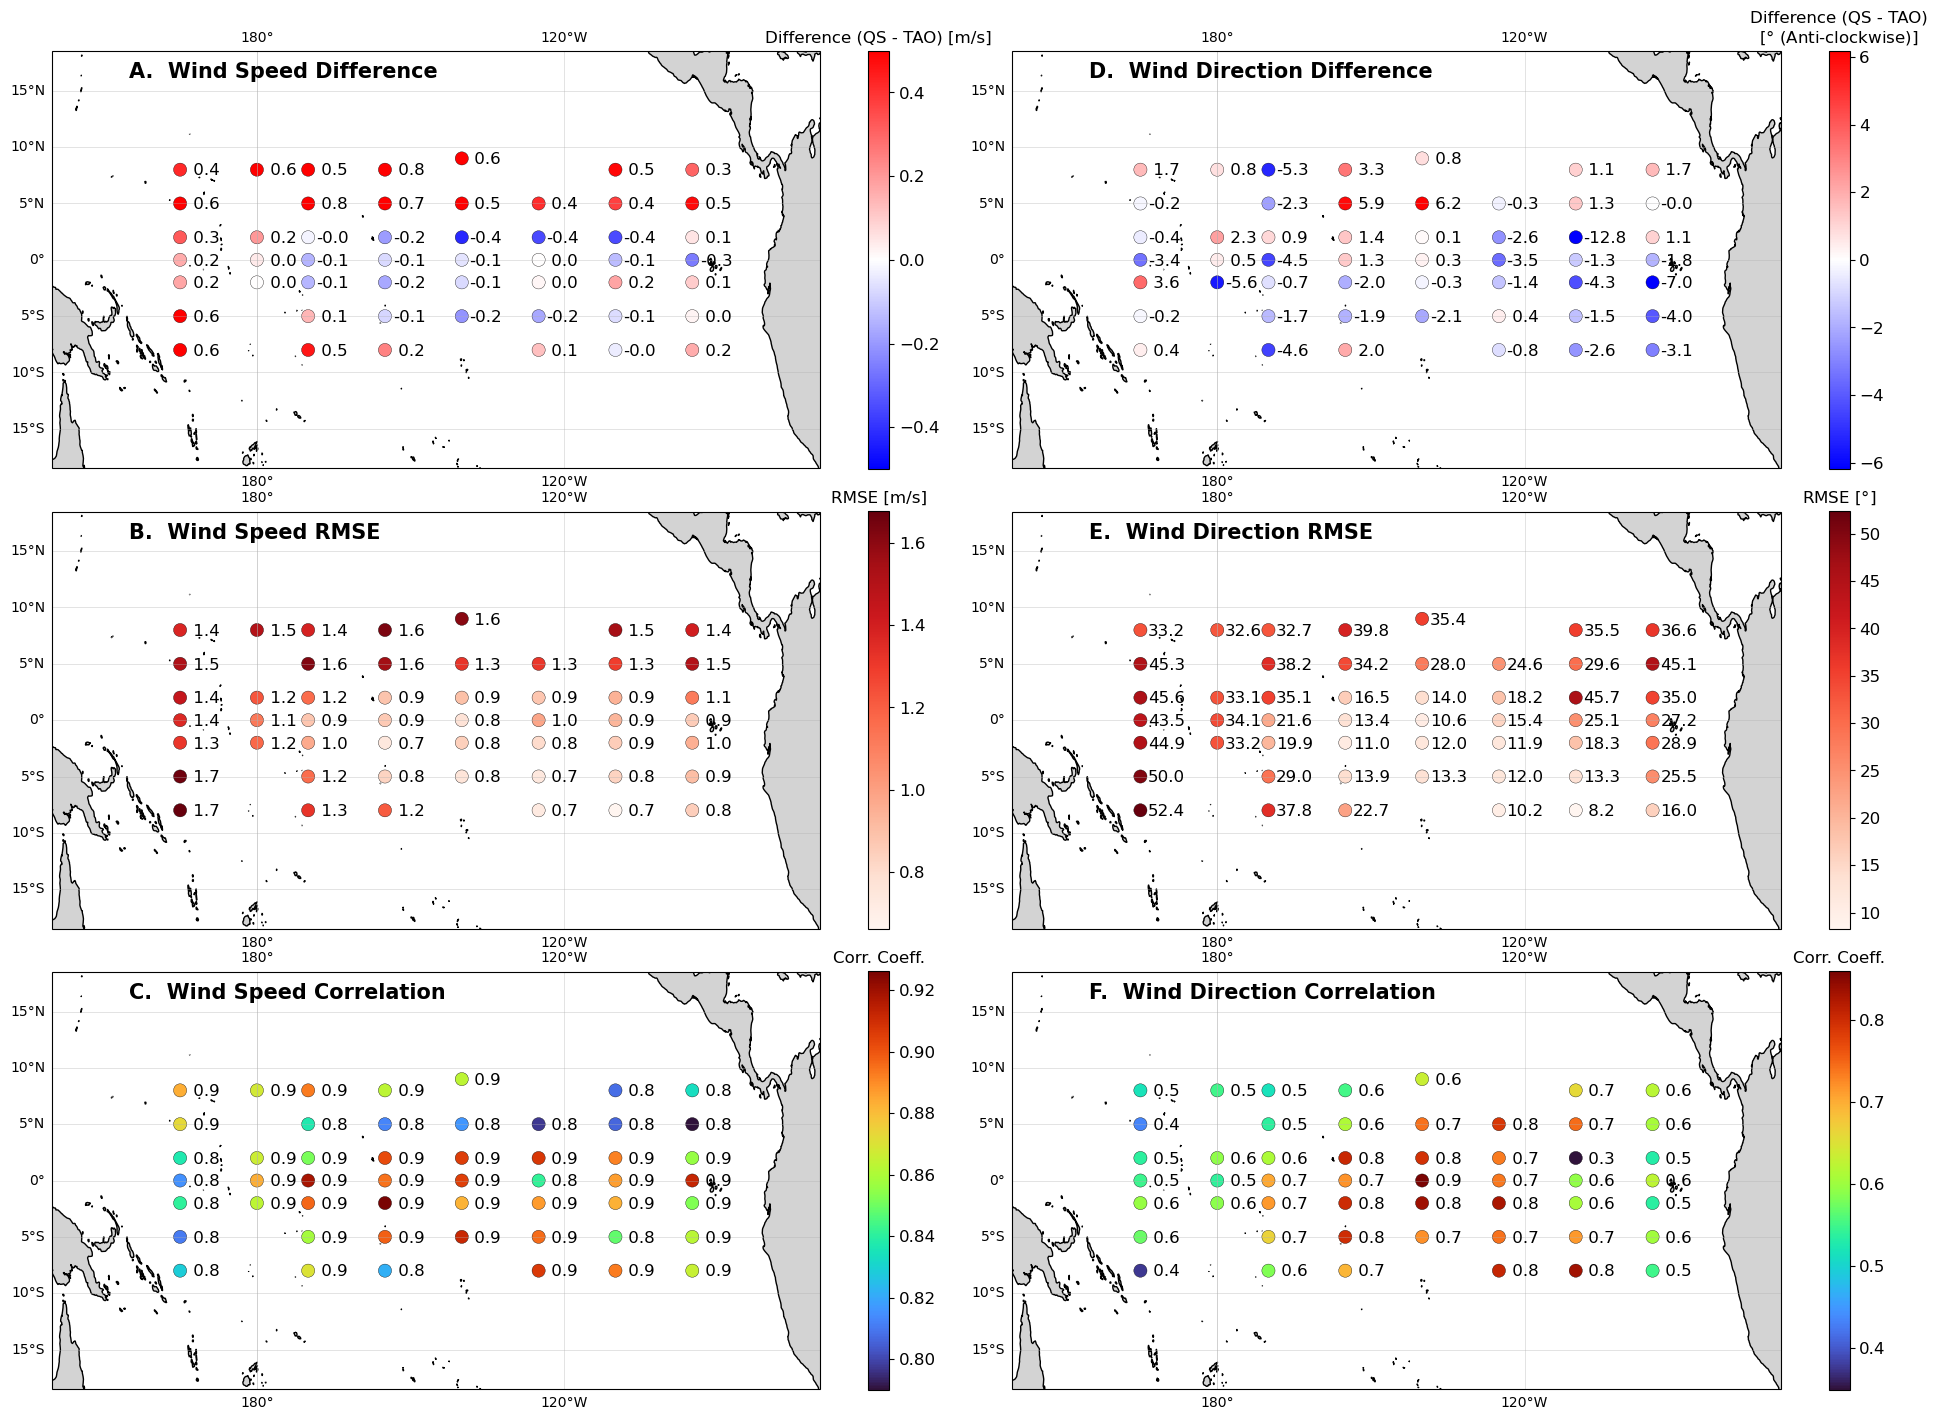

In [8]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 3, 
                       ncols = 2, 
                        figsize = (22*0.9,18*0.8),
                         sharex = True,
                         sharey = True, 
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180),  "aspect": 2.2}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)


fontSize = 15
fsz = 12
dotSize = 90
slw = 0.25
cbFs = 12
###################################################################################################################
ax = axes[0,0] 

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, alpha = 0.5)
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedDifference(lat, lon, df)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.bwr, vmin= -0.5, vmax= 0.5)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Difference (QS - TAO) [m/s]')

ax.text(0.1, 0.95, 'A.  Wind Speed Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)

###################################################################################################################
ax = axes[1,0]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, alpha = 0.5)
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedRMSE(lat, lon, df)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.Reds)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('RMSE [m/s]')

ax.text(0.1, 0.95, 'B.  Wind Speed RMSE', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[2,0]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, alpha = 0.5)
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, df)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.turbo)# vmin=0.40, vmax=0.85,)
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
###################################################################################################################
ax = axes[0,1] 

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, alpha = 0.5)
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirDifference(lat, lon, df)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.bwr, vmin= -np.max(plotList[:,2]), vmax= np.max(plotList[:,2]))
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Difference (QS - TAO)\n' + r'[$\degree$ (Anti-clockwise)]')

ax.text(0.1, 0.95, 'D.  Wind Direction Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)

###################################################################################################################
ax = axes[1,1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, alpha = 0.5)
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirRMSE(lat, lon, df)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.Reds)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title(r'RMSE [$\degree$]')

ax.text(0.1, 0.95, 'E.  Wind Direction RMSE', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[2,1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, alpha = 0.5)
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, df)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.turbo)# vmin=0.40, vmax=0.85,)
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'F.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################

plt.subplots_adjust(left = 0.03, right = 1, top =0.95 , bottom = 0.02, wspace=0 , hspace=0.1)

plt.savefig('BasicStats.pdf', dpi=100)

In [9]:
df['date'] = pd.to_datetime(df['QS_TIME'], errors='coerce')
df['week'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month

In [10]:
def getSpeedDifference_TS(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Neutral Wind Speed at 10m (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        corr = np.zeros((52), dtype=float)
        corr[:] = np.nan
        for i in range(52):
            ssubDF = subDF.loc[subDF['week'] == i]
            QSspeed = ssubDF['Wind Speed (QuikSCAT)'].to_numpy()
            TAOspeed = ssubDF[TAOlabel].to_numpy()
            if len(ssubDF) > 10:
                corr[i] = np.mean(QSspeed) - np.mean(TAOspeed)
            else:
                corr[i] = np.nan
        return corr
    else:
        return [-999]

def getSpeedRMSE_TS(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Neutral Wind Speed at 10m (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        corr = np.zeros((52), dtype=float)
        corr[:] = np.nan
        for i in range(52):
            ssubDF = subDF.loc[subDF['week'] == i]
            QSspeed = ssubDF['Wind Speed (QuikSCAT)'].to_numpy()
            TAOspeed = ssubDF[TAOlabel].to_numpy()
            if len(ssubDF) > 10:
                corr[i] = np.sqrt(np.mean((QSspeed - TAOspeed)**2))
            else:
                corr[i] = np.nan
        return corr
    else:
        return [-999]


def getSpeedCorrelation_TS(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Neutral Wind Speed at 10m (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        corr = np.zeros((52), dtype=float)
        corr[:] = np.nan
        for i in range(52):
            ssubDF = subDF.loc[subDF['week'] == i]
            QSspeed = ssubDF['Wind Speed (QuikSCAT)'].to_numpy()
            TAOspeed = ssubDF[TAOlabel].to_numpy()
            if len(ssubDF) > 10:
                corr[i] = np.corrcoef(QSspeed, TAOspeed)[0,1]
            else:
                corr[i] = np.nan
        return corr
    else:
        return [-999]

#########################################################################################

def getSpeedDifference_mTS(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Neutral Wind Speed at 10m (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        corr = np.zeros((12), dtype=float)
        corr[:] = np.nan
        for i in range(12):
            ssubDF = subDF.loc[subDF['month'] == i+1]
            QSspeed = ssubDF['Wind Speed (QuikSCAT)'].to_numpy()
            TAOspeed = ssubDF[TAOlabel].to_numpy()
            if len(ssubDF) > 10:
                corr[i] = np.mean(QSspeed) - np.mean(TAOspeed)
            else:
                corr[i] = np.nan
        return corr
    else:
        return [-999]

def getSpeedRMSE_mTS(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Neutral Wind Speed at 10m (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        corr = np.zeros((12), dtype=float)
        corr[:] = np.nan
        for i in range(12):
            ssubDF = subDF.loc[subDF['month'] == i+1]
            QSspeed = ssubDF['Wind Speed (QuikSCAT)'].to_numpy()
            TAOspeed = ssubDF[TAOlabel].to_numpy()
            if len(ssubDF) > 10:
                corr[i] = np.sqrt(np.mean((QSspeed - TAOspeed)**2))
            else:
                corr[i] = np.nan
        return corr
    else:
        return [-999]


def getSpeedCorrelation_mTS(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Neutral Wind Speed at 10m (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        corr = np.zeros((12), dtype=float)
        corr[:] = np.nan
        for i in range(12):
            ssubDF = subDF.loc[subDF['month'] == i+1]
            QSspeed = ssubDF['Wind Speed (QuikSCAT)'].to_numpy()
            TAOspeed = ssubDF[TAOlabel].to_numpy()
            if len(ssubDF) > 10:
                corr[i] = np.corrcoef(QSspeed, TAOspeed)[0,1]
            else:
                corr[i] = np.nan
        return corr
    else:
        return [-999]

#########################################################################################3

#########################################################################################3

def getDirDifference_mTS(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Wind Direction (TAO)'
        else:
            TAOlabel = f'mean WDIR {timeWindow}min'
        corr = np.zeros((12), dtype=float)
        corr[:] = np.nan
        for i in range(12):
            ssubDF = subDF.loc[subDF['month'] == i+1]
            QSdir = ssubDF['Wind Direction (QuikSCAT)'].to_numpy()
            TAOdir = ssubDF[TAOlabel].to_numpy()
            if len(ssubDF) > 10:
                corr[i] = np.mean(QSdir)- np.mean(TAOdir)
            else:
                corr[i] = np.nan
        return corr
    else:
        return [-999]


def getDirRMSE_mTS(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Wind Direction (TAO)'
        else:
            TAOlabel = f'mean WDIR {timeWindow}min'
        corr = np.zeros((12), dtype=float)
        corr[:] = np.nan
        for i in range(12):
            ssubDF = subDF.loc[subDF['month'] == i+1]
            QSdir = ssubDF['Wind Direction (QuikSCAT)'].to_numpy()
            TAOdir = ssubDF[TAOlabel].to_numpy()
            diff = QSdir - TAOdir
            diff[diff>180] -= 360
            diff[diff<-180] += 360
            if len(ssubDF) > 10:
                corr[i] = np.sqrt(np.mean(diff**2))
            else:
                corr[i] = np.nan
        return corr
    else:
        return [-999]
        
def getDirCorrelation_mTS(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Wind Direction (TAO)'
        else:
            TAOlabel = f'mean WDIR {timeWindow}min'
        corr = np.zeros((12), dtype=float)
        corr[:] = np.nan
        for i in range(12):
            ssubDF = subDF.loc[subDF['month'] == i+1]
            QSdir = ssubDF['Wind Direction (QuikSCAT)'].to_numpy()
            TAOdir = ssubDF[TAOlabel].to_numpy()
            if len(ssubDF) > 10:
                corr[i] = np.corrcoef(QSdir, TAOdir)[0,1]
            else:
                corr[i] = np.nan
                
        return corr
    else:
        return [-999]



In [11]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

corrSpeedArr = np.zeros((0,12), dtype=float)
differenceSpeedArr = np.zeros((0,12), dtype=float)
rmseSpeedArr = np.zeros((0,12), dtype=float)

group =[]
loc = []

for task in taskList:
    lat = task[0]
    lon = task[1]
    lon360 = (lon+360)%360
    xpos = lon + 180

    if xpos > 180:
       xpos -= 360
        
    corr = getSpeedCorrelation_mTS(lat, lon, df)
    difference = getSpeedDifference_mTS(lat, lon, df)
    rmse = getSpeedRMSE_mTS(lat, lon, df)
    
    if len(corr) > 1: 
        lonUnit = 'E' if lon > 0 else 'W' 
        latUnit = 'N' if lat > 0 else 'S'
        loc.append(f'({abs(lon)}{lonUnit}, {abs(lat)}{latUnit})')
        if lat > 5:
            group.append(0)
        elif lat == 5:
            group.append(1)
        elif abs(lat) <= 2:
            if lon360 >=180 and lon360 < 240:
                group.append(2)
            elif lon360 < 180:
                group.append(3)
            elif lon360 >= 240:
                group.append(4)
        elif lat == -5:
            group.append(5)
        elif lat < -5:
            group.append(6)
        corrSpeedArr = np.concatenate((corrSpeedArr, np.array([corr])), axis=0)
        differenceSpeedArr = np.concatenate((differenceSpeedArr, np.array([difference])), axis=0)
        rmseSpeedArr = np.concatenate((rmseSpeedArr, np.array([rmse])), axis=0)
        

In [12]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

corrDirArr = np.zeros((0,12), dtype=float)
differenceDirArr = np.zeros((0,12), dtype=float)
rmseDirArr = np.zeros((0,12), dtype=float)

group =[]
loc = []

for task in taskList:
    lat = task[0]
    lon = task[1]
    lon360 = (lon+360)%360
    xpos = lon + 180

    if xpos > 180:
       xpos -= 360
        
    corr = getDirCorrelation_mTS(lat, lon, df)
    difference = getDirDifference_mTS(lat, lon, df)
    rmse = getDirRMSE_mTS(lat, lon, df)
    
    if len(corr) > 1: 
        lonUnit = 'E' if lon > 0 else 'W' 
        latUnit = 'N' if lat > 0 else 'S'
        loc.append(f'({abs(lon)}{lonUnit}, {abs(lat)}{latUnit})')
        if lat > 5:
            group.append(0)
        elif lat == 5:
            group.append(1)
        elif abs(lat) <= 2:
            if lon360 >=180 and lon360 < 240:
                group.append(2)
            elif lon360 < 180:
                group.append(3)
            elif lon360 >= 240:
                group.append(4)
        elif lat == -5:
            group.append(5)
        elif lat < -5:
            group.append(6)
        corrDirArr = np.concatenate((corrDirArr, np.array([corr])), axis=0)
        differenceDirArr = np.concatenate((differenceDirArr, np.array([difference])), axis=0)
        rmseDirArr = np.concatenate((rmseDirArr, np.array([rmse])), axis=0)

In [13]:
group = np.array(group)
loc = np.array(loc)
print(corrSpeedArr.shape, differenceSpeedArr.shape, rmseSpeedArr.shape, group.shape)
print(corrDirArr.shape, differenceDirArr.shape, rmseDirArr.shape, group.shape)

(51, 12) (51, 12) (51, 12) (51,)
(51, 12) (51, 12) (51, 12) (51,)


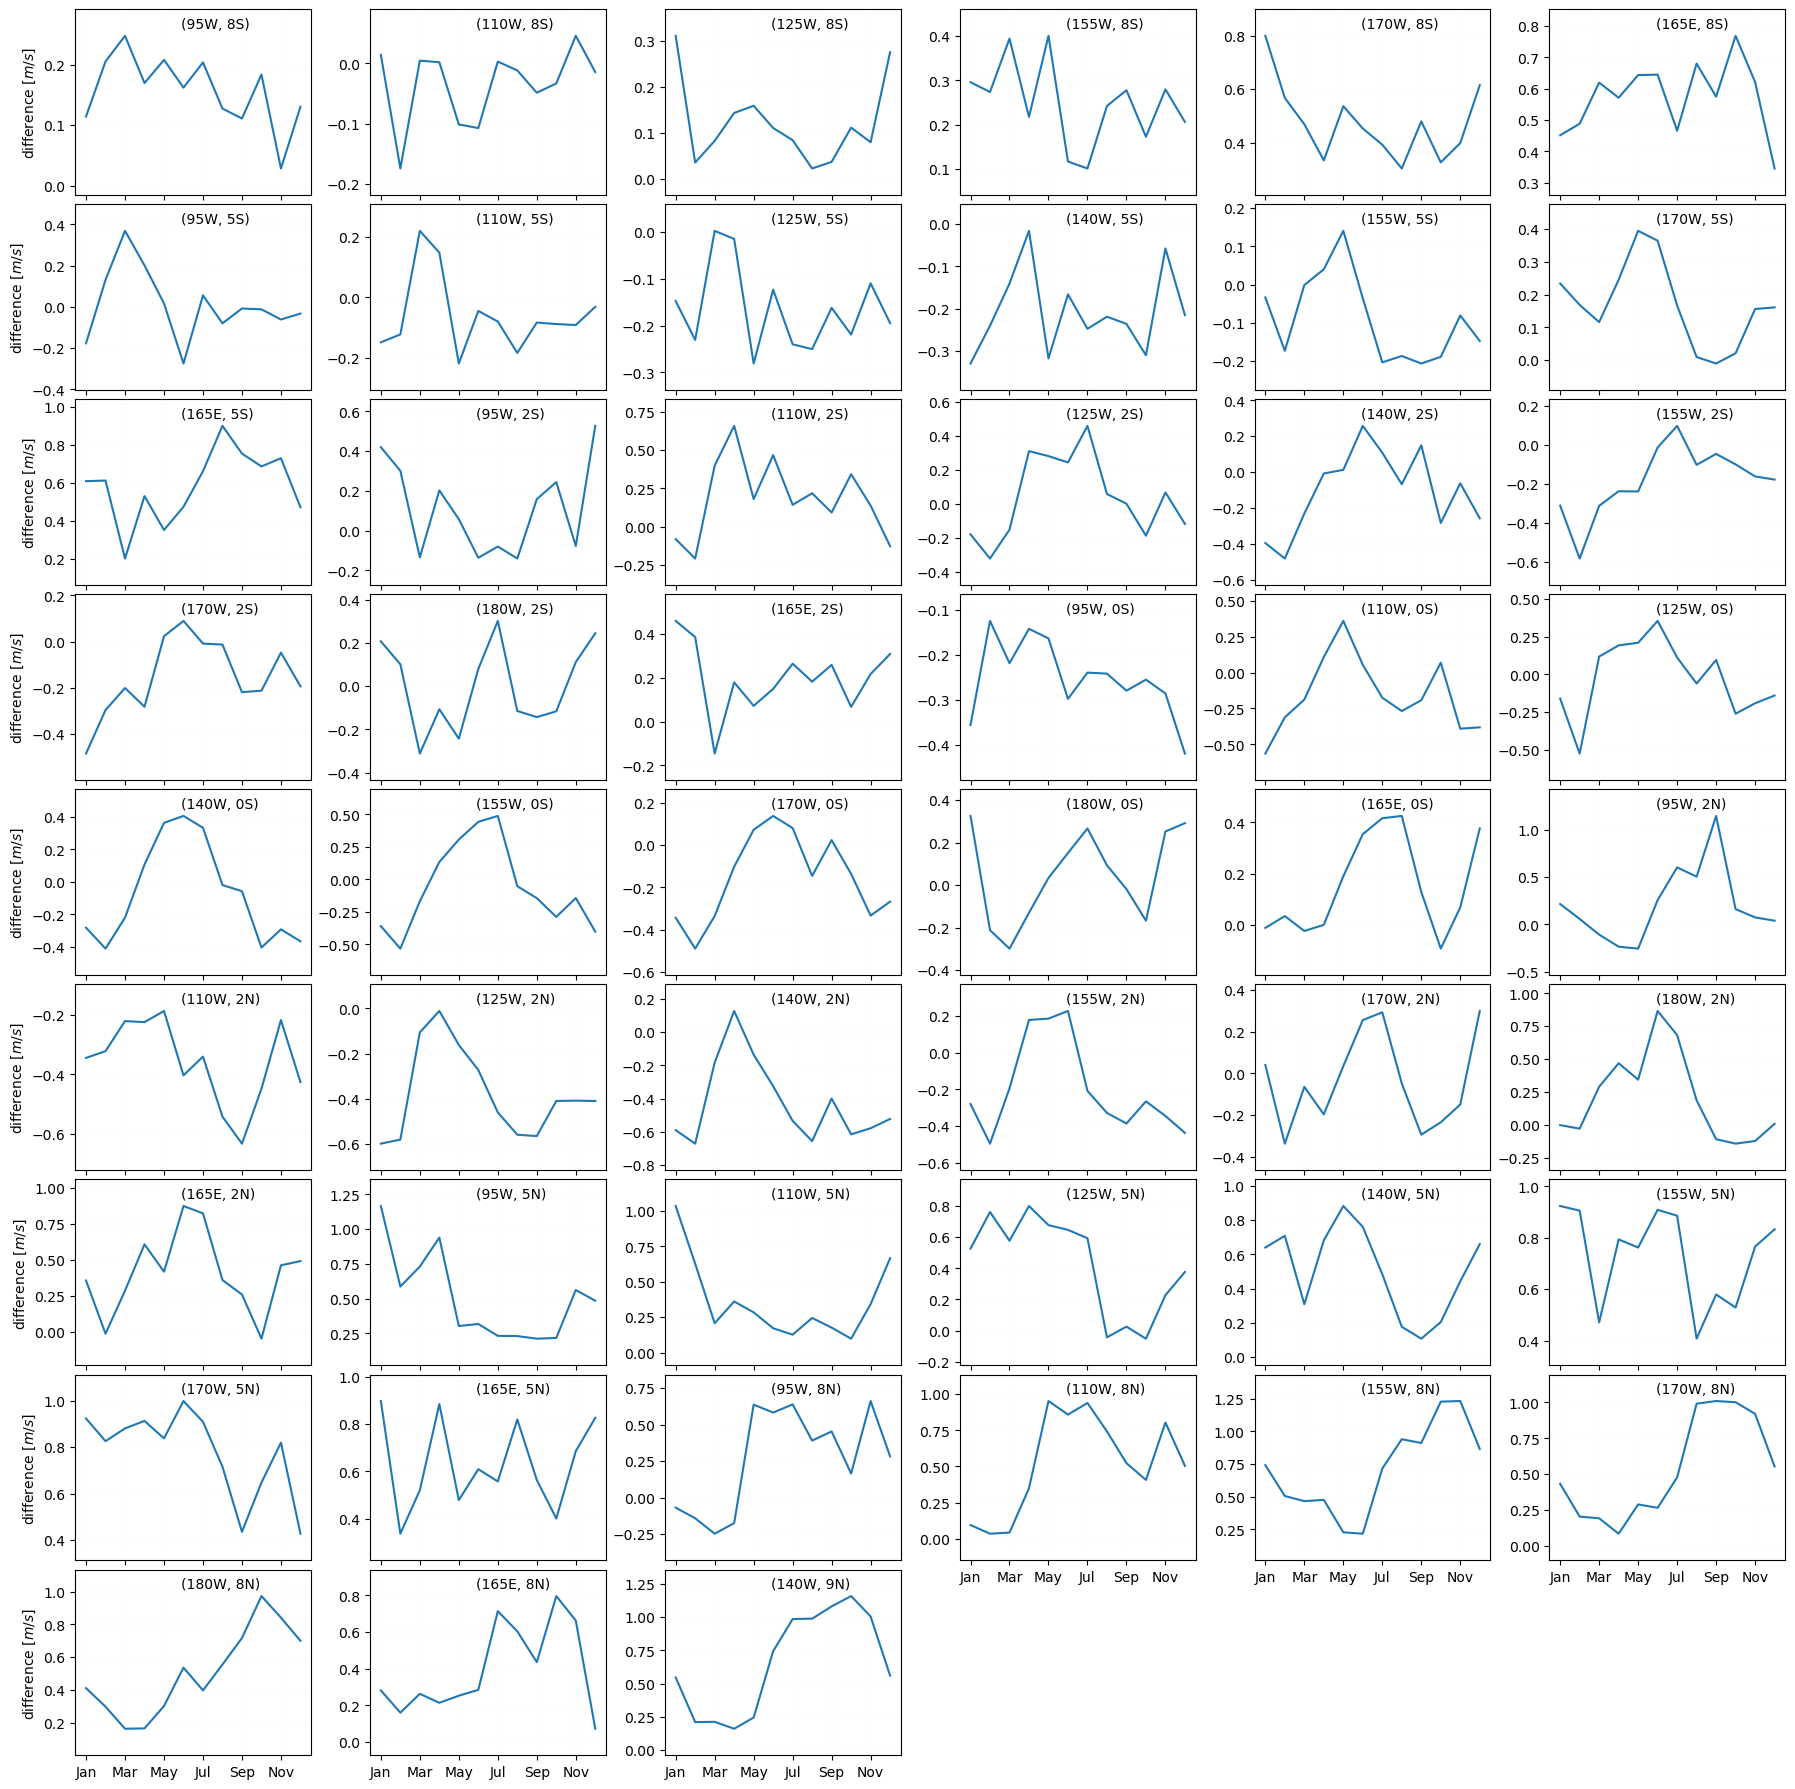

In [14]:
nx = 6
ny = int(51//nx) + 1
fig, axes  = plt.subplots(nrows = ny, ncols =nx, figsize = (18,18), sharex = False)
xlabels = ['Jan', 
          'Feb',
          'Mar',
          'Apr',
          'May',
          'Jun',
          'Jul',
          'Aug',
          'Sep',
          'Oct',
          'Nov',
          'Dec']

ylabel = r'difference [$m/s$] '

maxRowInEachCol = np.zeros(nx, dtype = int)
for i in range(51):
    pltArr = differenceSpeedArr[i,:].T
    ii = int(i//nx)
    jj = i%nx
    ax = axes[ii,jj]
    ax.plot(xlabels, pltArr)
    vmin = np.min(pltArr)
    vmax = np.max(pltArr)
    yrange = vmax - vmin
    ax.set_ylim(vmin - 0.2*yrange, vmax + 0.2* yrange)
    ax.text(0.45, 0.90, loc[i], transform= ax.transAxes)
    ax.grid(linewidth = 0.01, alpha=0.25)
    axes[ii, jj].set_xticks(np.arange(12)[::2])
    ax.set_xticklabels([])
    if jj == 0:
        ax.set_ylabel(ylabel)
    if maxRowInEachCol[jj] < ii:
        maxRowInEachCol[jj] = ii
        

# Hide unused subplots
for i in range(51, nx * ny):
    ii = int(i//nx)
    jj = i%nx
    fig.delaxes(axes[ii, jj])  # removes unused axes cleanly


for i in range(nx):
    ii = maxRowInEachCol[i]
    jj = i%nx
    axes[ii, jj].set_xticklabels(xlabels[::2], ha='center')

plt.subplots_adjust(left = 0.04, right = 0.99, top = 0.99, bottom =0.02, wspace = 0.25, hspace = 0.05)
plt.savefig('DifferenceSpeedSeasonality.pdf', dpi = 100)

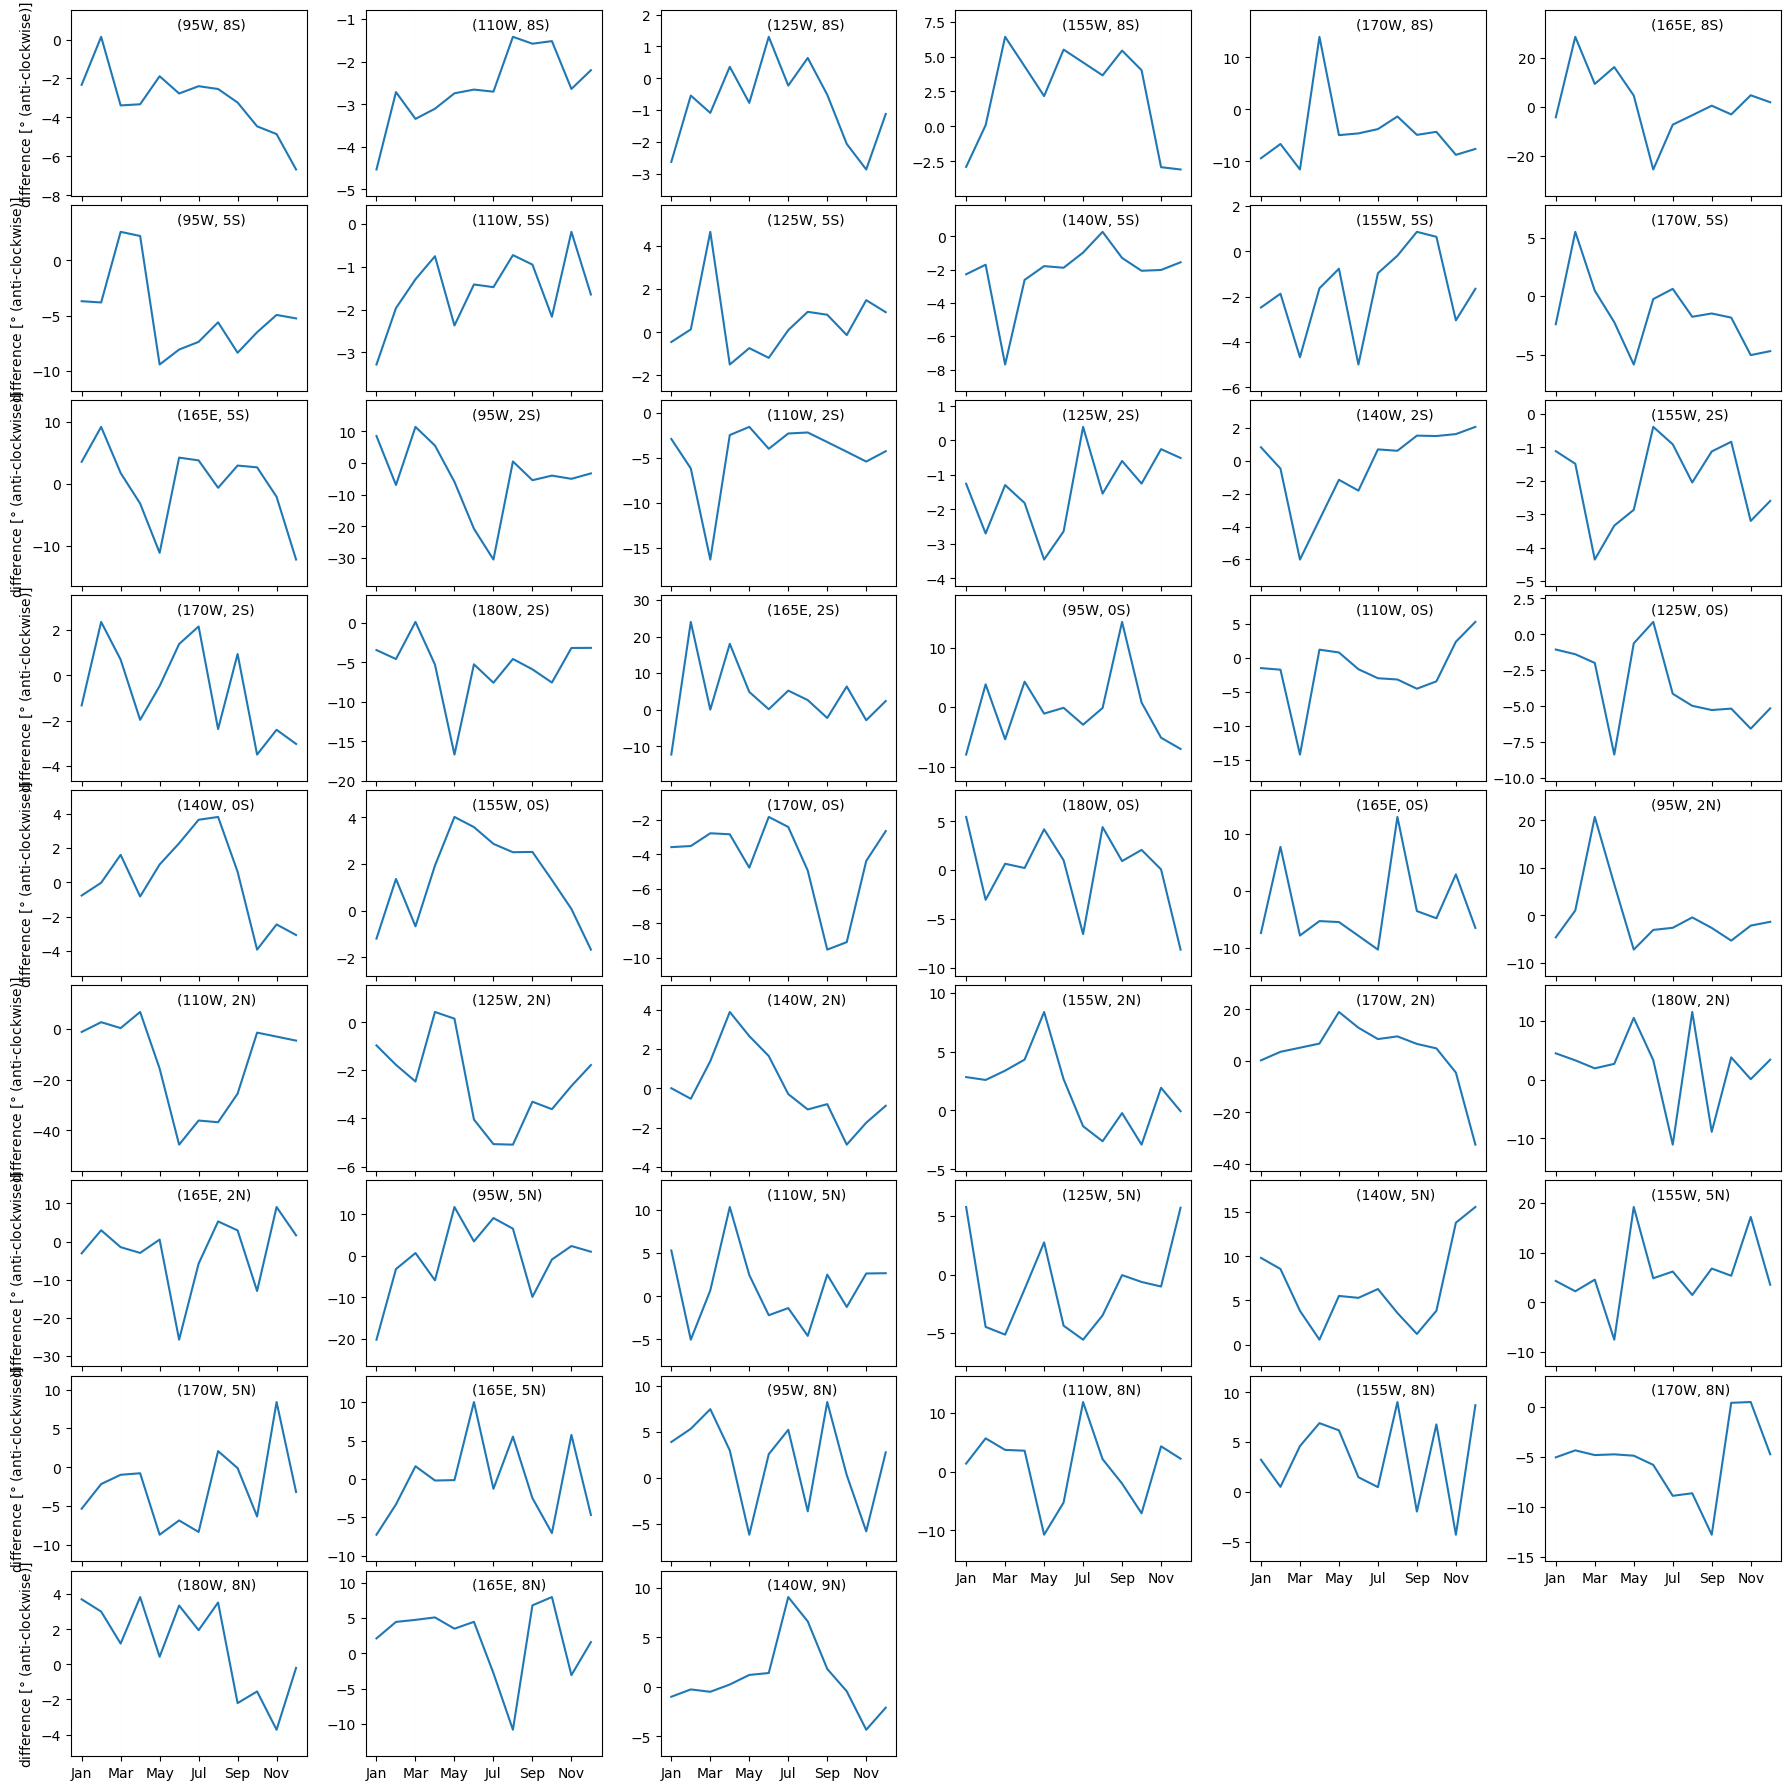

In [15]:
nx = 6
ny = int(51//nx) + 1
fig, axes  = plt.subplots(nrows = ny, ncols =nx, figsize = (18,18), sharex = False)
xlabels = ['Jan', 
          'Feb',
          'Mar',
          'Apr',
          'May',
          'Jun',
          'Jul',
          'Aug',
          'Sep',
          'Oct',
          'Nov',
          'Dec']

ylabel = r'difference [$\degree$ (anti-clockwise)] '

maxRowInEachCol = np.zeros(nx, dtype = int)
for i in range(51):
    pltArr = differenceDirArr[i,:].T
    ii = int(i//nx)
    jj = i%nx
    ax = axes[ii,jj]
    ax.plot(xlabels, pltArr)
    vmin = np.min(pltArr)
    vmax = np.max(pltArr)
    yrange = vmax - vmin
    ax.set_ylim(vmin - 0.2*yrange, vmax + 0.2* yrange)
    ax.text(0.45, 0.90, loc[i], transform= ax.transAxes)
    ax.grid(linewidth = 0.01, alpha=0.25)
    axes[ii, jj].set_xticks(np.arange(12)[::2])
    ax.set_xticklabels([])
    if jj == 0:
        ax.set_ylabel(ylabel)
    if maxRowInEachCol[jj] < ii:
        maxRowInEachCol[jj] = ii
        

# Hide unused subplots
for i in range(51, nx * ny):
    ii = int(i//nx)
    jj = i%nx
    fig.delaxes(axes[ii, jj])  # removes unused axes cleanly


for i in range(nx):
    ii = maxRowInEachCol[i]
    jj = i%nx
    axes[ii, jj].set_xticklabels(xlabels[::2], ha='center')

plt.subplots_adjust(left = 0.04, right = 0.99, top = 0.99, bottom =0.02, wspace = 0.25, hspace = 0.05)
plt.savefig('DifferenceDirectionSeasonality.pdf', dpi = 100)

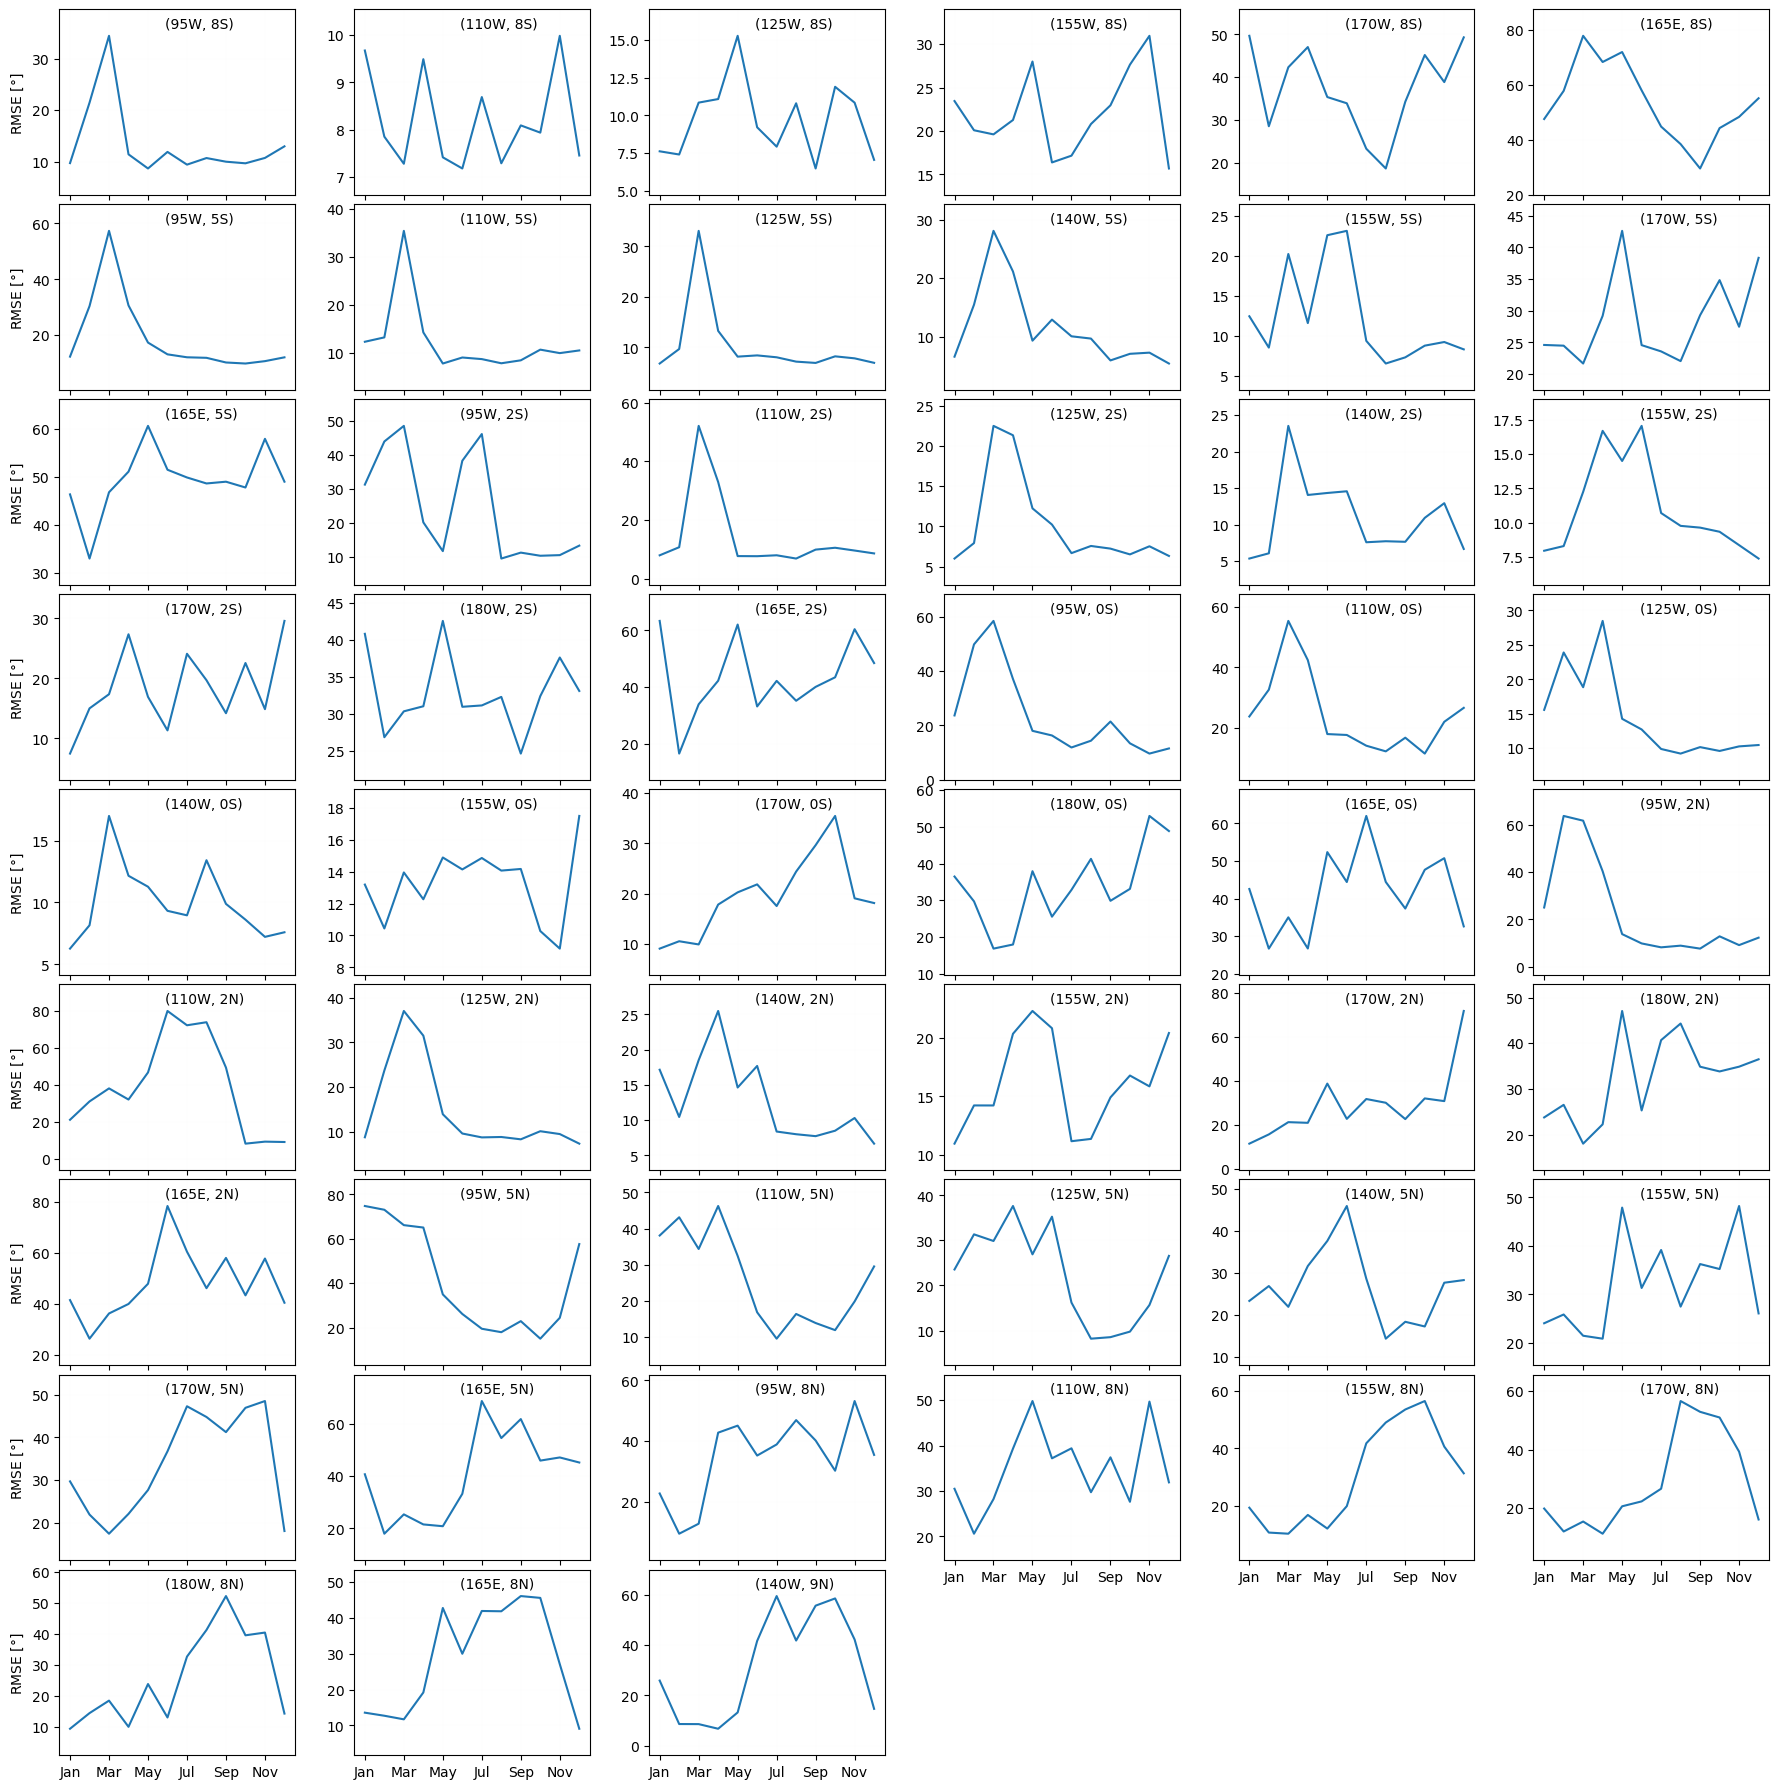

In [16]:
nx = 6
ny = int(51//nx) + 1
fig, axes  = plt.subplots(nrows = ny, ncols =nx, figsize = (18,18), sharex = False)
xlabels = ['Jan', 
          'Feb',
          'Mar',
          'Apr',
          'May',
          'Jun',
          'Jul',
          'Aug',
          'Sep',
          'Oct',
          'Nov',
          'Dec']

ylabel = r'RMSE [$\degree$] '

maxRowInEachCol = np.zeros(nx, dtype = int)
for i in range(51):
    pltArr = rmseDirArr[i,:].T
    ii = int(i//nx)
    jj = i%nx
    ax = axes[ii,jj]
    ax.plot(xlabels, pltArr)
    vmin = np.min(pltArr)
    vmax = np.max(pltArr)
    yrange = vmax - vmin
    ax.set_ylim(vmin - 0.2*yrange, vmax + 0.2* yrange)
    ax.text(0.45, 0.90, loc[i], transform= ax.transAxes)
    ax.grid(linewidth = 0.01, alpha=0.25)
    axes[ii, jj].set_xticks(np.arange(12)[::2])
    ax.set_xticklabels([])
    if jj == 0:
        ax.set_ylabel(ylabel)
    if maxRowInEachCol[jj] < ii:
        maxRowInEachCol[jj] = ii
        

# Hide unused subplots
for i in range(51, nx * ny):
    ii = int(i//nx)
    jj = i%nx
    fig.delaxes(axes[ii, jj])  # removes unused axes cleanly


for i in range(nx):
    ii = maxRowInEachCol[i]
    jj = i%nx
    axes[ii, jj].set_xticklabels(xlabels[::2], ha='center')

plt.subplots_adjust(left = 0.04, right = 0.99, top = 0.99, bottom =0.02, wspace = 0.25, hspace = 0.05)
plt.savefig('RMSE_DirectionSeasonality.pdf', dpi = 100)

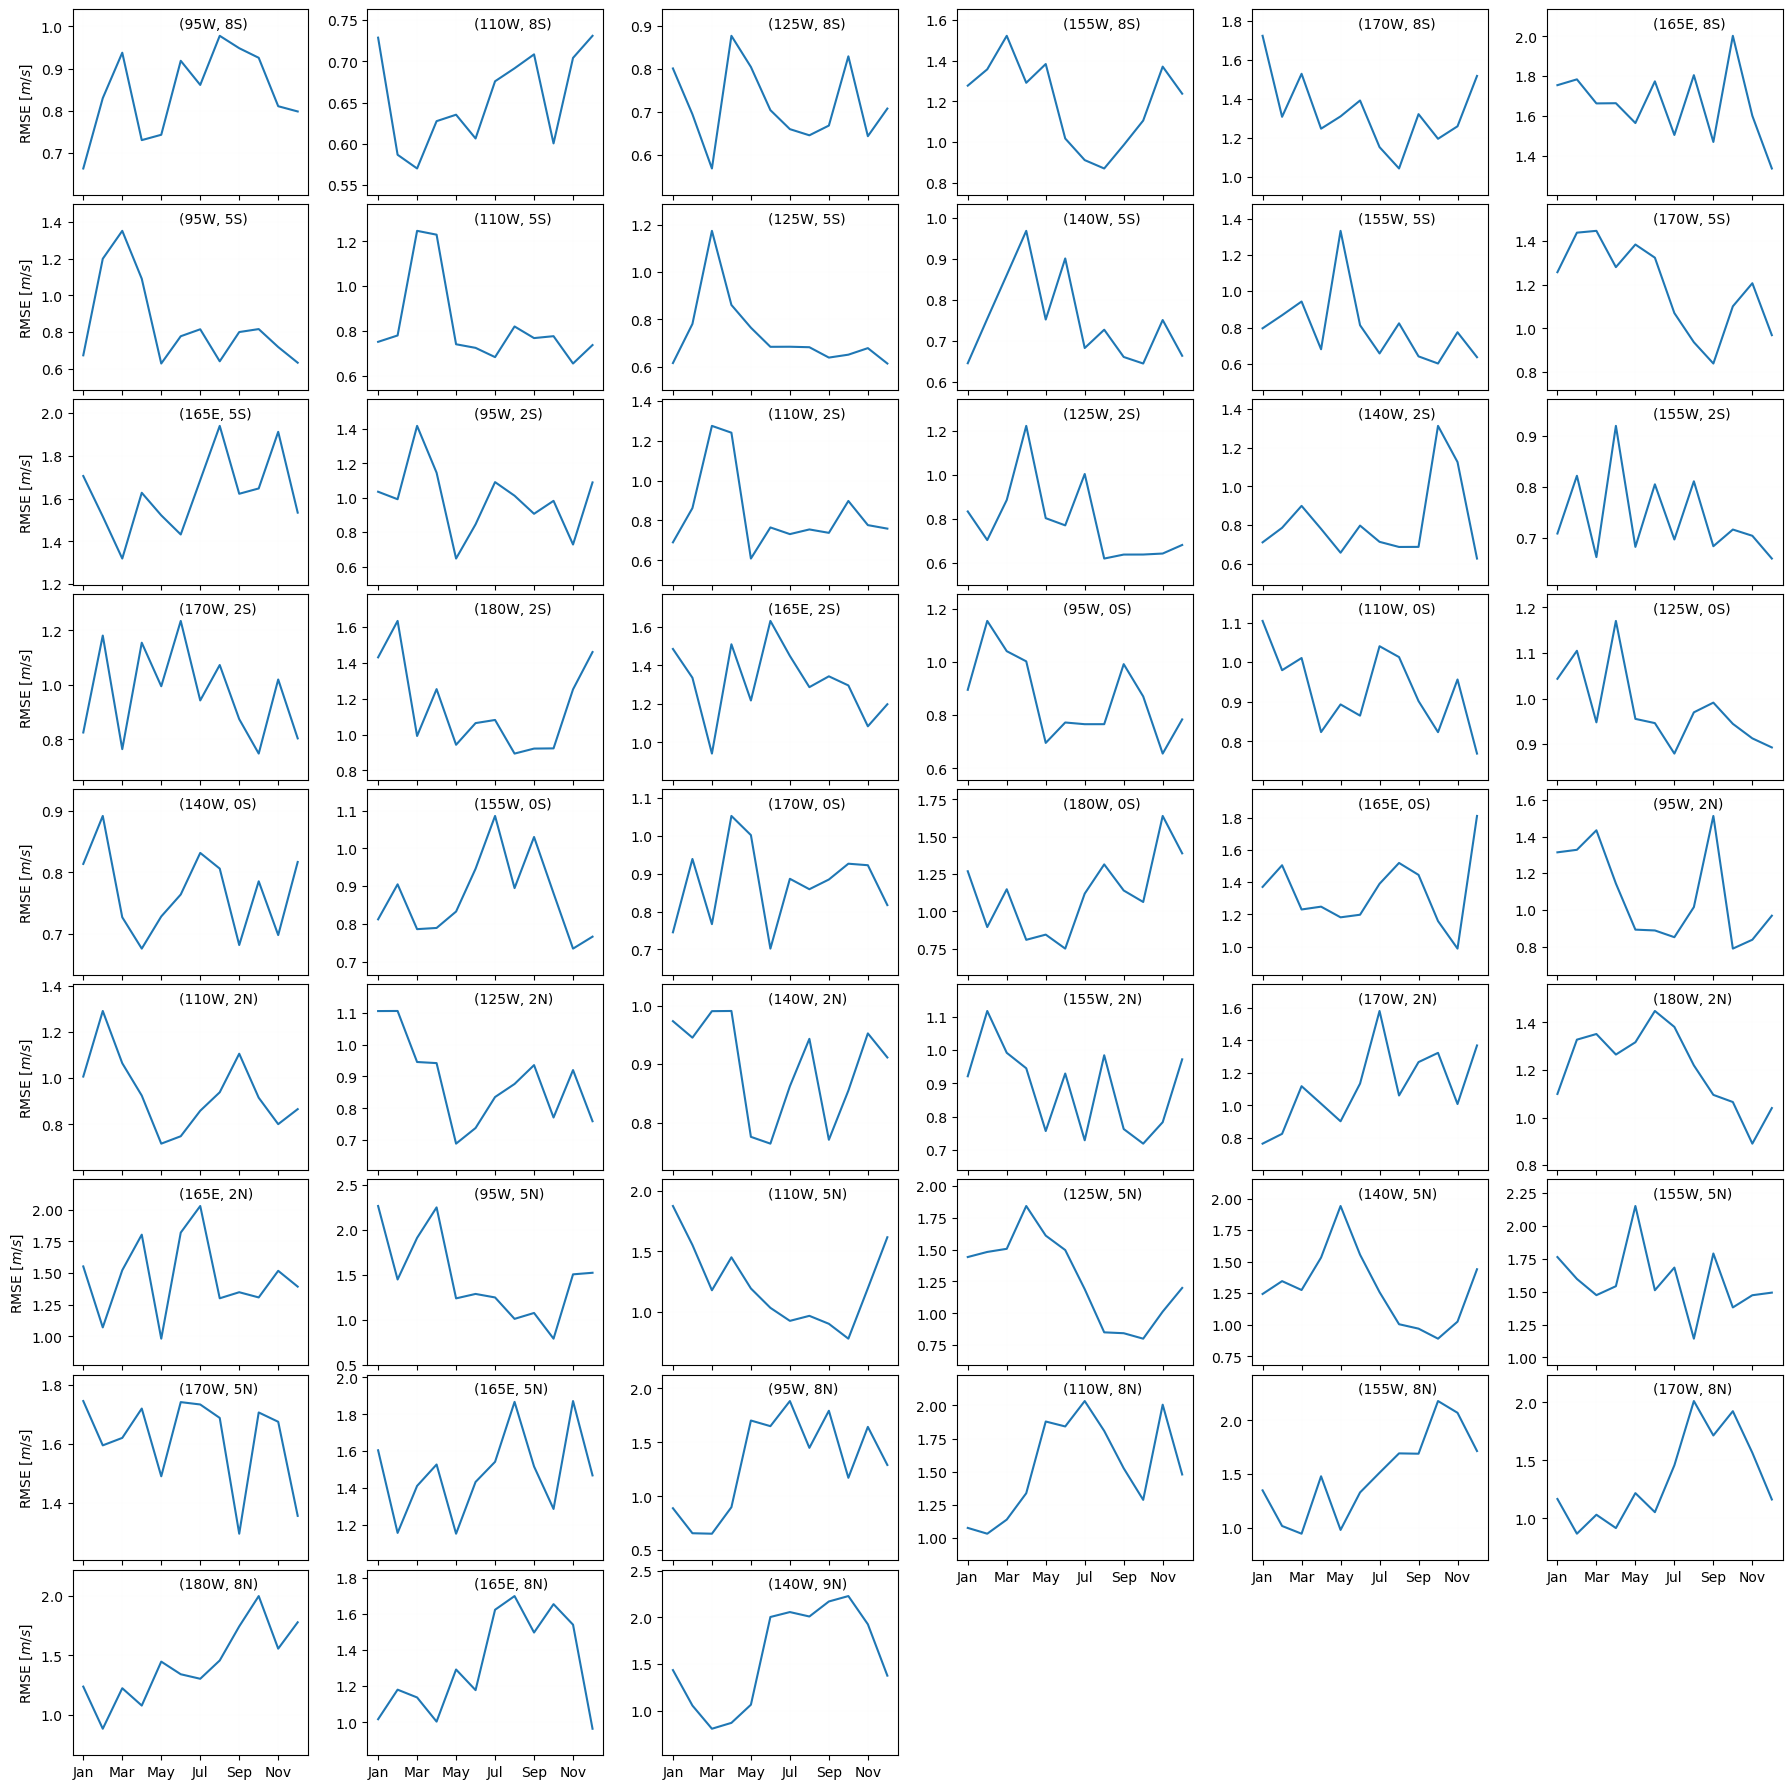

In [17]:
nx = 6
ny = int(51//nx) + 1
fig, axes  = plt.subplots(nrows = ny, ncols =nx, figsize = (18,18), sharex = False)
xlabels = ['Jan', 
          'Feb',
          'Mar',
          'Apr',
          'May',
          'Jun',
          'Jul',
          'Aug',
          'Sep',
          'Oct',
          'Nov',
          'Dec']

ylabel = r'RMSE [$m/s$] '

maxRowInEachCol = np.zeros(nx, dtype = int)
for i in range(51):
    pltArr = rmseSpeedArr[i,:].T
    ii = int(i//nx)
    jj = i%nx
    ax = axes[ii,jj]
    ax.plot(xlabels, pltArr)
    vmin = np.min(pltArr)
    vmax = np.max(pltArr)
    yrange = vmax - vmin
    ax.set_ylim(vmin - 0.2*yrange, vmax + 0.2* yrange)
    ax.text(0.45, 0.90, loc[i], transform= ax.transAxes)
    ax.grid(linewidth = 0.01, alpha=0.25)
    axes[ii, jj].set_xticks(np.arange(12)[::2])
    ax.set_xticklabels([])
    if jj == 0:
        ax.set_ylabel(ylabel)
    if maxRowInEachCol[jj] < ii:
        maxRowInEachCol[jj] = ii
        

# Hide unused subplots
for i in range(51, nx * ny):
    ii = int(i//nx)
    jj = i%nx
    fig.delaxes(axes[ii, jj])  # removes unused axes cleanly


for i in range(nx):
    ii = maxRowInEachCol[i]
    jj = i%nx
    axes[ii, jj].set_xticklabels(xlabels[::2], ha='center')

plt.subplots_adjust(left = 0.04, right = 0.99, top = 0.99, bottom =0.02, wspace = 0.25, hspace = 0.05)
plt.savefig('RMSE_SpeedSeasonality.pdf', dpi = 100)

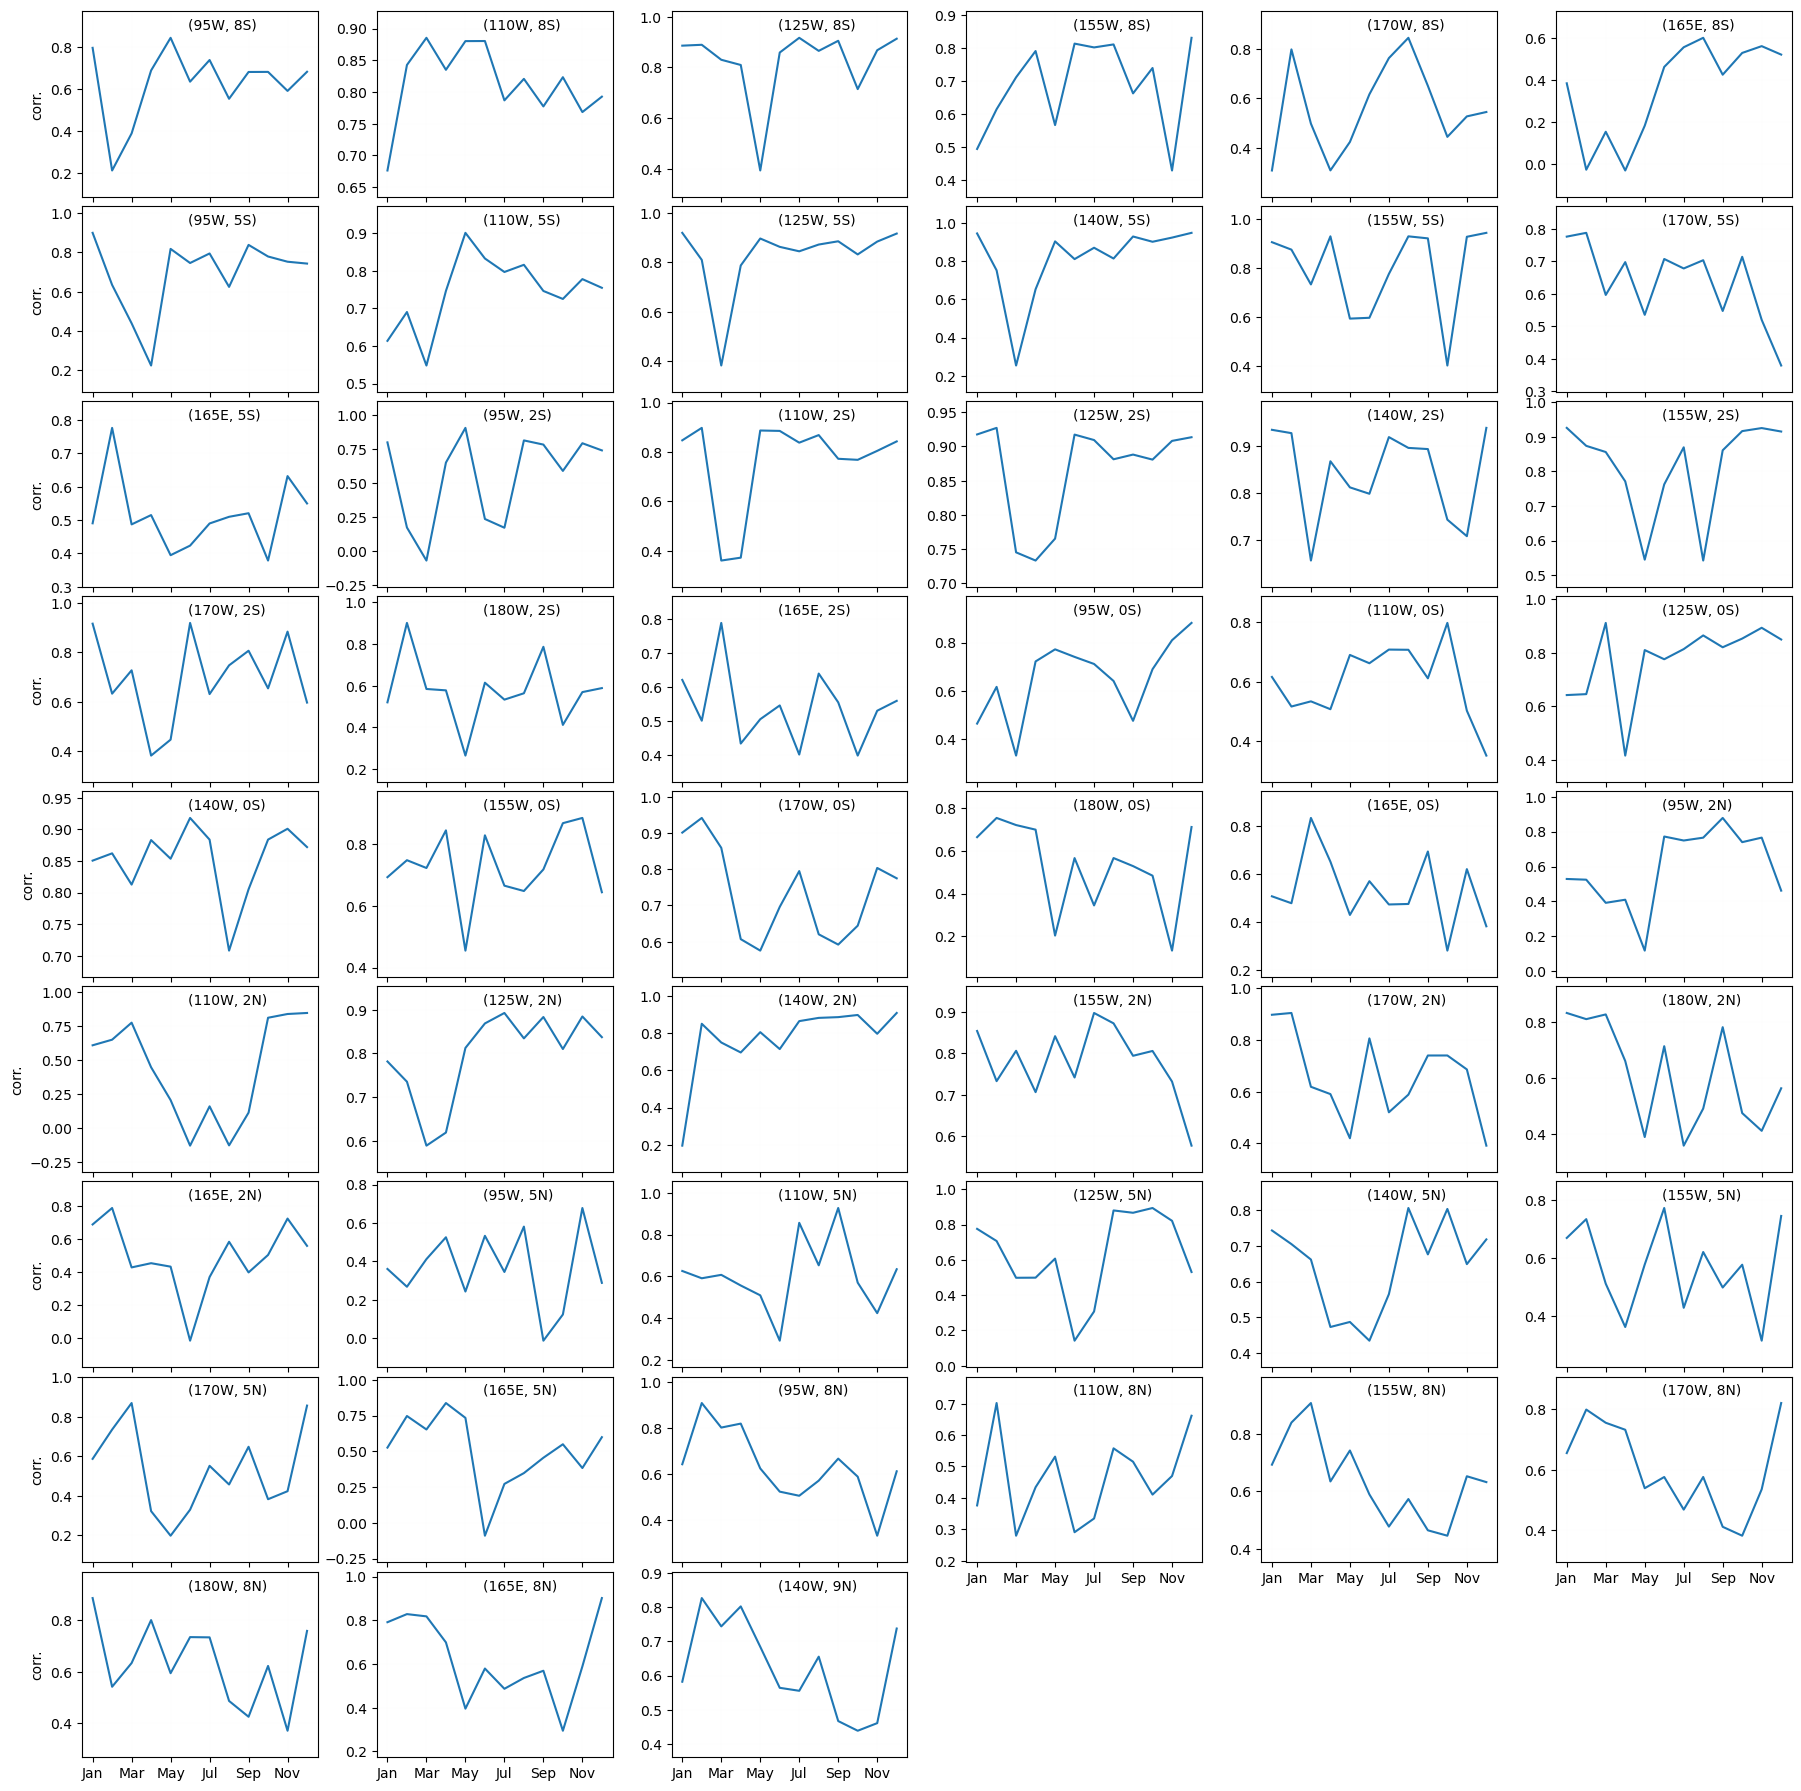

In [18]:
nx = 6
ny = int(51//nx) + 1
fig, axes  = plt.subplots(nrows = ny, ncols =nx, figsize = (18,18), sharex = False)
xlabels = ['Jan', 
          'Feb',
          'Mar',
          'Apr',
          'May',
          'Jun',
          'Jul',
          'Aug',
          'Sep',
          'Oct',
          'Nov',
          'Dec']

ylabel = r'corr.'

maxRowInEachCol = np.zeros(nx, dtype = int)
for i in range(51):
    pltArr = corrDirArr[i,:].T
    ii = int(i//nx)
    jj = i%nx
    ax = axes[ii,jj]
    ax.plot(xlabels, pltArr)
    vmin = np.min(pltArr)
    vmax = np.max(pltArr)
    yrange = vmax - vmin
    ax.set_ylim(vmin - 0.2*yrange, vmax + 0.2* yrange)
    ax.text(0.45, 0.90, loc[i], transform= ax.transAxes)
    ax.grid(linewidth = 0.01, alpha=0.25)
    axes[ii, jj].set_xticks(np.arange(12)[::2])
    ax.set_xticklabels([])
    if jj == 0:
        ax.set_ylabel(ylabel)
    if maxRowInEachCol[jj] < ii:
        maxRowInEachCol[jj] = ii
        

# Hide unused subplots
for i in range(51, nx * ny):
    ii = int(i//nx)
    jj = i%nx
    fig.delaxes(axes[ii, jj])  # removes unused axes cleanly


for i in range(nx):
    ii = maxRowInEachCol[i]
    jj = i%nx
    axes[ii, jj].set_xticklabels(xlabels[::2], ha='center')

plt.subplots_adjust(left = 0.04, right = 0.99, top = 0.99, bottom =0.02, wspace = 0.25, hspace = 0.05)
plt.savefig('corr_DirectionSeasonality.pdf', dpi = 100)

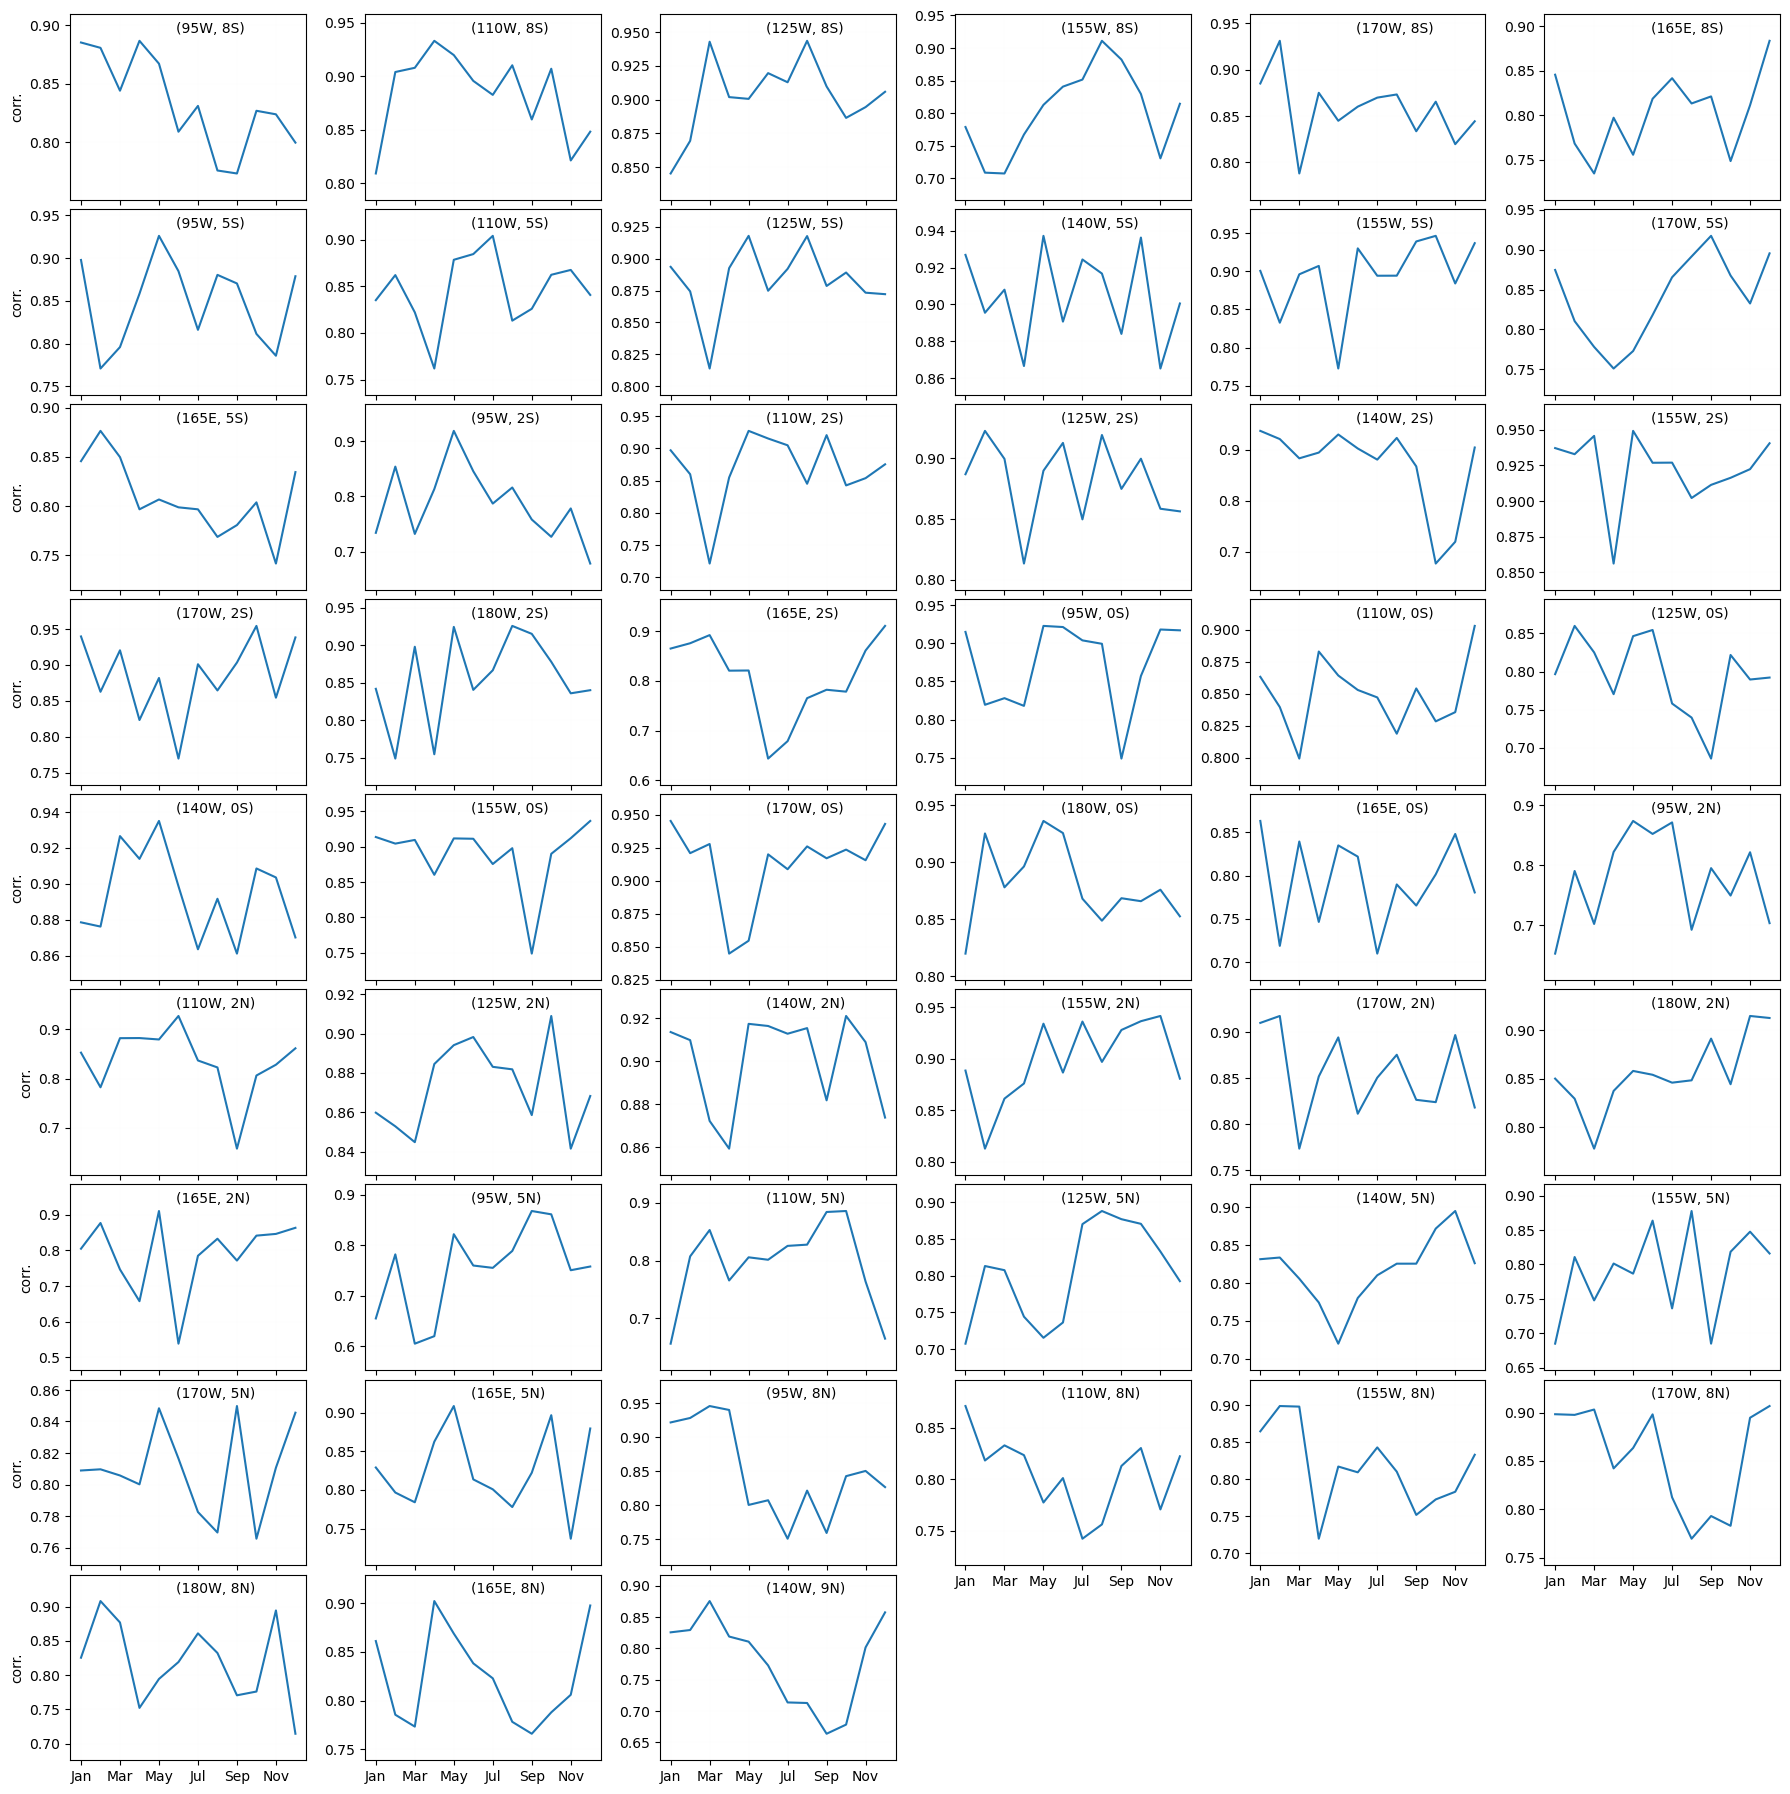

In [19]:
nx = 6
ny = int(51//nx) + 1
fig, axes  = plt.subplots(nrows = ny, ncols =nx, figsize = (18,18), sharex = False)
xlabels = ['Jan', 
          'Feb',
          'Mar',
          'Apr',
          'May',
          'Jun',
          'Jul',
          'Aug',
          'Sep',
          'Oct',
          'Nov',
          'Dec']

ylabel = r'corr.'

maxRowInEachCol = np.zeros(nx, dtype = int)
for i in range(51):
    pltArr = corrSpeedArr[i,:].T
    ii = int(i//nx)
    jj = i%nx
    ax = axes[ii,jj]
    ax.plot(xlabels, pltArr)
    vmin = np.min(pltArr)
    vmax = np.max(pltArr)
    yrange = vmax - vmin
    ax.set_ylim(vmin - 0.2*yrange, vmax + 0.2* yrange)
    ax.text(0.45, 0.90, loc[i], transform= ax.transAxes)
    ax.grid(linewidth = 0.01, alpha=0.25)
    axes[ii, jj].set_xticks(np.arange(12)[::2])
    ax.set_xticklabels([])
    if jj == 0:
        ax.set_ylabel(ylabel)
    if maxRowInEachCol[jj] < ii:
        maxRowInEachCol[jj] = ii
        

# Hide unused subplots
for i in range(51, nx * ny):
    ii = int(i//nx)
    jj = i%nx
    fig.delaxes(axes[ii, jj])  # removes unused axes cleanly


for i in range(nx):
    ii = maxRowInEachCol[i]
    jj = i%nx
    axes[ii, jj].set_xticklabels(xlabels[::2], ha='center')

plt.subplots_adjust(left = 0.04, right = 0.99, top = 0.99, bottom =0.02, wspace = 0.25, hspace = 0.05)
plt.savefig('corr_SpeedSeasonality.pdf', dpi = 100)

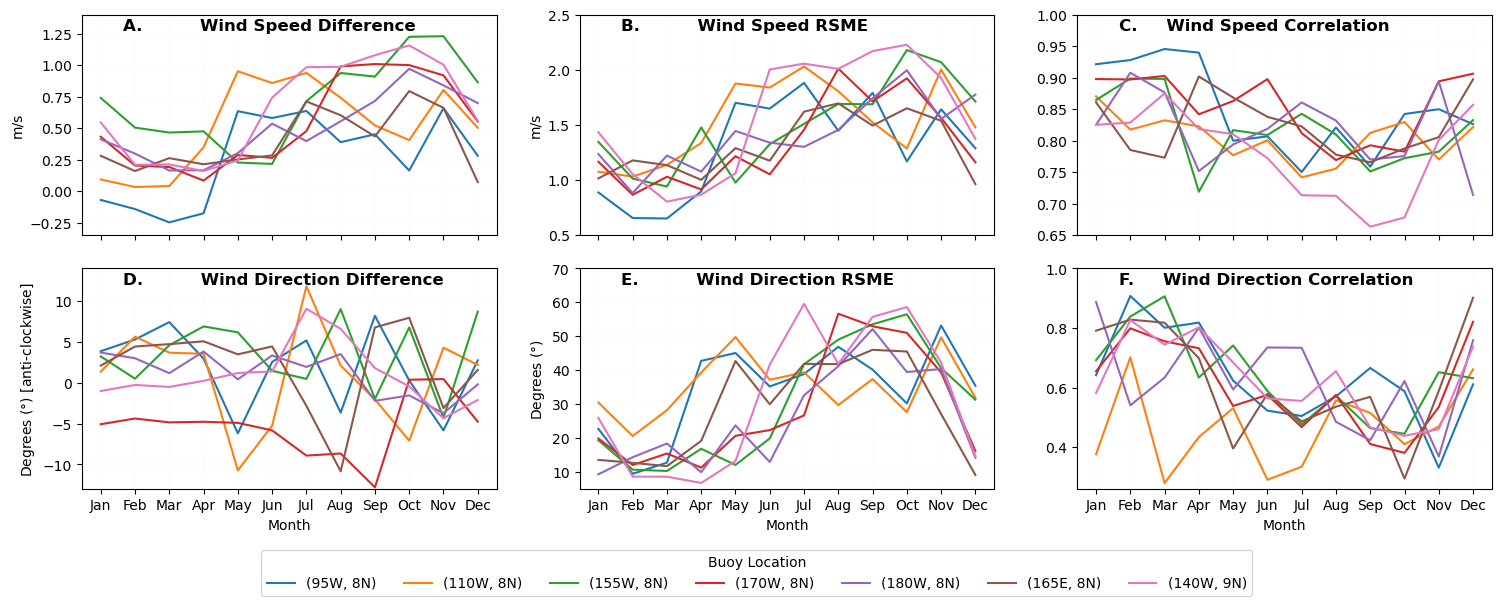

In [20]:
fig, axes  = plt.subplots(nrows = 2, ncols =3, figsize = (15,6), sharex = True)

fontSize = 12
mask = group == 0

i = 0 
ax = axes[i,0]
xlabels = ['Jan', 
          'Feb',
          'Mar',
          'Apr',
          'May',
          'Jun',
          'Jul',
          'Aug',
          'Sep',
          'Oct',
          'Nov',
          'Dec']

ax.plot(xlabels, differenceSpeedArr[mask,:].T, label =loc[mask])
ax.text(0.1, 0.95, 'A.          Wind Speed Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)
ax.set_ylim([-0.35, 1.4])
ax.set_ylabel('m/s')
ax.grid(linewidth = 0.1, alpha=0.25)

ax = axes[i,1]
ax.plot(xlabels, rmseSpeedArr[mask,:].T, label =loc[mask])
ax.text(0.1, 0.95, 'B.          Wind Speed RSME', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)
ax.set_ylabel('m/s')
ax.set_ylim([0.5, 2.5])
ax.grid(linewidth = 0.1, alpha=0.25)

ax = axes[i,2]
ax.plot(corrSpeedArr[mask,:].T,  label =loc[mask])
ax.text(0.1, 0.95, 'C.     Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)
ax.set_ylim([0.65, 1])
ax.grid(linewidth = 0.1, alpha=0.25)

i = 1 
ax = axes[i,0]
ax.plot(xlabels, differenceDirArr[mask,:].T,  label =loc[mask])
ax.text(0.1, 0.95, 'D.          Wind Direction Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)
ax.set_xlabel('Month')
ax.set_ylim([-13, 14])
ax.set_ylabel(r'Degrees ($\degree$) [anti-clockwise]')
ax.grid(linewidth = 0.1, alpha=0.25)

ax = axes[i,1]
ax.plot(xlabels, rmseDirArr[mask,:].T,  label =loc[mask])
ax.text(0.1, 0.95, 'E.          Wind Direction RSME', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)
ax.set_xlabel('Month')
ax.set_ylabel(r'Degrees ($\degree$)')
ax.set_ylim([5, 70])
ax.grid(linewidth = 0.1, alpha=0.25)

ax = axes[i,2]
ax.plot(xlabels, corrDirArr[mask,:].T,  label =loc[mask])
ax.text(0.1, 0.95, 'F.     Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)
ax.set_xlabel('Month')
ax.set_ylim([0.26, 1])
ax.grid(linewidth = 0.1, alpha=0.25)

# 🌟 Add a single common legend
handles, labels = axes[0, 0].get_legend_handles_labels()  # or gather from multiple if needed
fig.legend(handles, labels, loc='lower center', title='Buoy Location', ncol=len(labels), bbox_to_anchor=(0.5, 0.01))

plt.subplots_adjust(left=0.05, right = 0.99, top=0.99, bottom = 0.2, wspace=0.20, hspace=0.15)
plt.savefig('Seasonality.pdf', dpi=100)
